# Installlations

In [1]:
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric
#!pip install -U sentence-transformers

Looking in links: https://data.pyg.org/whl/torch-+.html
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp38-cp38-macosx_11_0_arm64.whl size=247022 sha256=df2640db7b8f9f14e3a28f7c1debd6561ebb30e1ce7f6cf9fa63750a55e297db
  Stored in directory: /Users/pratham/Library/Caches/pip/wheels/7c/51/2a/409339f45a48bf748a5db76dfa11373ea7c883ecf1932eee2f
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-+.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.15-cp38-cp38-macosx_11_0_arm64.whl size=459763 sha256=3660e5612f5276e955aee8d9782a277751bac4ed59e1e73f4dca0cd3c8014004
  Stored in directory: /Users/pratham/Library/Caches/pip/wheels/3c/4e/f2/2d7bcec11f628aa3070dceb8fcdfb84907c4f745f213e49dab
Successfully built torch-sparse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 6.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 9.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 10.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 999.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 3.5 MB/s eta 0:00:00
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.4.41-cp38-cp38-macosx_11_0_arm64.whl size=1549831 sha256=9ebb36a4f41734e629a940afeae3f31ba04fdb072c04b5d5

# Model definitions

In [7]:
import torch
from torch_geometric.datasets import UPFD
import numpy as np
from torch_geometric.loader import DataLoader

In [8]:
import torch.nn.functional as F
from torch.nn import ReLU, LeakyReLU, Softmax, Linear, SELU, GELU, ELU,Dropout
from torch_geometric.nn import SAGEConv, global_max_pool, TopKPooling

In [9]:
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, f1_score 

In [14]:
test_data_pol = UPFD(root=".", name="politifact", feature="bert",split="train")
train_data_pol = UPFD(root=".", name="politifact", feature="bert", split="test")
val_data_pol = UPFD(root=".", name="politifact", feature="bert", split="val")
# train_data_pol = train_data_pol + val_data_pol

In [15]:
train_loader = DataLoader(train_data_pol, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data_pol, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_pol, batch_size=32, shuffle=True)

In [11]:

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels[0])
        self.conv2 = SAGEConv(hidden_channels[0], hidden_channels[1])
        self.conv3 = SAGEConv(hidden_channels[1], hidden_channels[2])
        
        self.full1 = Linear(hidden_channels[2],hidden_channels[3])
        self.full2 = Linear(hidden_channels[3],hidden_channels[4])
        self.full3 = Linear(hidden_channels[4],hidden_channels[5])

        self.full4 = Linear(hidden_channels[5],out_channels)

        #droupouts
        self.dp1 = Dropout(0.2)
        self.dp2 = Dropout(0.2)
        self.dp3 = Dropout(0.2)


    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        h = global_max_pool(h,batch)

        h = self.full1(h).relu()
        h = self.dp1(h)
        h = self.full2(h).relu()
        h = self.dp2(h)
        h = self.full3(h).relu()
        h = self.dp3(h)
        
        h = self.full4(h)

        return torch.sigmoid(h)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyper Parameter Tuning

- Number neurons in each layer
- learning rate
- Beta 1 of Adam Optimize also called momentum

In [41]:
def objective(trial):
  
  model = Net(768,[trial.suggest_categorical(name="layer_size1",choices = [256,512]),
                   trial.suggest_categorical(name="layer_size2",choices = [256,512]),
                   trial.suggest_categorical(name="layer_size3",choices = [256,512]),
                   trial.suggest_categorical(name="layer_size4",choices = [64,128,512]),
                   trial.suggest_categorical(name="layer_size5",choices = [64,128,512]),
                   trial.suggest_categorical(name="layer_size6",choices = [64,128,512]),

  
  ],1).to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=trial.suggest_loguniform('learning_rate', 1e-6, 1e-3),betas=(trial.suggest_loguniform('b1', 1-1e-1,1-1e-3),0.99))
  lossff = torch.nn.BCELoss()

  total_loss = 0
  weighted_loss = 0
  exp_param = 0.8

  wloss = []

  for i in range(600):
    print("Epoch:", i)
    model.train()
    for data in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          out = model(data.x, data.edge_index, data.batch)
          loss = lossff(torch.reshape(out,(-1,)), data.y.float())
          loss.backward()
          optimizer.step()
          total_loss += float(loss) * data.num_graphs
    print("Train: ",total_loss / len(train_loader.dataset))

    model.eval()
    total_loss = 0
    for data in val_loader:
          data = data.to(device)
          out = model(data.x, data.edge_index, data.batch)
          loss = lossff(torch.reshape(out,(-1,)), data.y.float())
          total_loss += float(loss) * data.num_graphs
          
    print("Test", total_loss / len(val_loader.dataset))

    weighted_loss = exp_param*(weighted_loss) + (1-exp_param)*(total_loss/ len(val_loader.dataset))
    print(weighted_loss/(1-exp_param**(i+1)))
    wloss.append(weighted_loss/(1-exp_param**(i+1)))

    if(i-30>=0 and wloss[i-20]-weighted_loss<0.01):
      break

  return weighted_loss

In [42]:
import optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=20)

[I 2022-10-16 05:56:23,941] A new study created in memory with name: no-name-fc3ffb2f-514b-429a-ab80-f9de943b2a38
/var/folders/5r/z92hbcf14gx38w5z2nf1210w0000gn/T/ipykernel_53308/466619184.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  optimizer = torch.optim.Adam(model.parameters(),lr=trial.suggest_loguniform('learning_rate', 1e-6, 1e-3),betas=(trial.suggest_loguniform('b1', 1-1e-1,1-1e-3),0.99))


Epoch: 0
Train:  0.6932932847765236
Test 0.6980131268501282
0.6980131268501282
Epoch: 1
Train:  0.7915146437165964
Test 0.6963661909103394
0.6970981624391345
Epoch: 2
Train:  0.7914332577545719
Test 0.6951037049293518
0.696280761820371
Epoch: 3
Train:  0.7899675614693585
Test 0.6941914558410645
0.6955730023422861
Epoch: 4
Train:  0.7892284474221829
Test 0.6931468844413757
0.6948512871171223
Epoch: 5
Train:  0.7901976664141832
Test 0.6920807957649231
0.694100329924337
Epoch: 6
Train:  0.7888829333210423
Test 0.6910011768341064
0.6933160169550806
Epoch: 7
Train:  0.7875912728892193
Test 0.6901895999908447
0.6925646801662907
Epoch: 8
Train:  0.7871230943170608
Test 0.6895183324813843
0.6918609587380685
Epoch: 9
Train:  0.7867448405442734
Test 0.6888068914413452
0.6911766703752393
Epoch: 10
Train:  0.7856241208395807
Test 0.6880888342857361
0.690501069482554
Epoch: 11
Train:  0.7835118258161242
Test 0.6872237324714661
0.6897972349387794
Epoch: 12
Train:  0.7842600820291096
Test 0.686354398

[I 2022-10-16 06:08:00,123] Trial 0 finished with value: 0.38741885250162544 and parameters: {'layer_size1': 256, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 512, 'layer_size5': 128, 'layer_size6': 64, 'learning_rate': 3.28934533167165e-05, 'b1': 0.998112210667536}. Best is trial 0 with value: 0.38741885250162544.


Train:  0.2563836398572404
Test 0.3878130316734314
0.3874188525274855
Epoch: 0
Train:  0.6948622343766743
Test 0.6984020471572876
0.6984020471572876
Epoch: 1
Train:  0.7927552564111771
Test 0.6982921361923218
0.6983409855100845
Epoch: 2
Train:  0.7925487592209518
Test 0.6981660723686218
0.6982692997963703
Epoch: 3
Train:  0.7918210660710054
Test 0.6980740427970886
0.6982031558264239
Epoch: 4
Train:  0.7913928433780757
Test 0.6979750394821167
0.698135296371311
Epoch: 5
Train:  0.7924287885562327
Test 0.6979028582572937
0.6980722927191033
Epoch: 6
Train:  0.7910173778080832
Test 0.6978173851966858
0.6980077824254933
Epoch: 7
Train:  0.7914189159600443
Test 0.6977236270904541
0.697939494554941
Epoch: 8
Train:  0.7915958802624525
Test 0.6976227760314941
0.6978663310047761
Epoch: 9
Train:  0.7915951064808876
Test 0.6975158452987671
0.6977878018609627
Epoch: 10
Train:  0.7916395478119138
Test 0.6974022388458252
0.697703442876333
Epoch: 11
Train:  0.7911902822520398
Test 0.6973013877868652
0.

[I 2022-10-16 06:08:53,053] Trial 1 finished with value: 0.695398614409811 and parameters: {'layer_size1': 256, 'layer_size2': 512, 'layer_size3': 512, 'layer_size4': 128, 'layer_size5': 128, 'layer_size6': 128, 'learning_rate': 3.4142768387675937e-06, 'b1': 0.9250503780212823}. Best is trial 0 with value: 0.38741885250162544.


Train:  0.7907745484852683
Test 0.695838987827301
0.6960879865613548
Epoch: 0
Train:  0.6950251516713276
Test 0.6994564533233643
0.6994564533233643
Epoch: 1
Train:  0.7924356867824744
Test 0.69889235496521
0.699143065346612
Epoch: 2
Train:  0.7925705610357259
Test 0.698448657989502
0.6988584721674684
Epoch: 3
Train:  0.7918961805995234
Test 0.6980832815170288
0.6985958737086474
Epoch: 4
Train:  0.791691186740927
Test 0.697795033454895
0.6983576418387781
Epoch: 5
Train:  0.7919913899844588
Test 0.6975086331367493
0.6981275132765578
Epoch: 6
Train:  0.7911236847148222
Test 0.6972493529319763
0.6979052743205304
Epoch: 7
Train:  0.7914904868440931
Test 0.6967929601669312
0.6976379643123481
Epoch: 8
Train:  0.7903076202621288
Test 0.6963974833488464
0.6973514070557215
Epoch: 9
Train:  0.7902111831833335
Test 0.6958886981010437
0.6970236753397353
Epoch: 10
Train:  0.7897583672363834
Test 0.6951211094856262
0.6966074048019959
Epoch: 11
Train:  0.7900813259690056
Test 0.6945551037788391
0.6961

[I 2022-10-16 06:13:57,273] Trial 2 finished with value: 0.2790117843189192 and parameters: {'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 1.433675124157315e-05, 'b1': 0.9286759768614723}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.1765466347269343
Test 0.2820148169994354
0.27901178431893103
Epoch: 0
Train:  0.6929551112166358
Test 0.6905836462974548
0.6905836462974547
Epoch: 1
Train:  0.7900893672019648
Test 0.6905653476715088
0.6905734803941516
Epoch: 2
Train:  0.7898065348016731
Test 0.6905441880226135
0.690561475323849
Epoch: 3
Train:  0.7892397437160371
Test 0.6905303597450256
0.6905509348161175
Epoch: 4
Train:  0.7892829503408924
Test 0.6905169486999512
0.6905408247149257
Epoch: 5
Train:  0.7889391766414383
Test 0.6905049681663513
0.6905311055966766
Epoch: 6
Train:  0.7895898071888885
Test 0.6904933452606201
0.6905215494629747
Epoch: 7
Train:  0.7894493020497836
Test 0.6904816627502441
0.6905119639358357
Epoch: 8
Train:  0.7887193811425256
Test 0.6904691457748413
0.6905020727282241
Epoch: 9
Train:  0.789761210998259
Test 0.6904563903808594
0.6904918372305577
Epoch: 10
Train:  0.7910024326850925
Test 0.6904468536376953
0.6904819950774728
Epoch: 11
Train:  0.7888948429224178
Test 0.6904332637786865


[I 2022-10-16 06:14:58,211] Trial 3 finished with value: 0.6895324694106032 and parameters: {'layer_size1': 512, 'layer_size2': 256, 'layer_size3': 512, 'layer_size4': 128, 'layer_size5': 64, 'layer_size6': 128, 'learning_rate': 1.1114098894037444e-06, 'b1': 0.9813140635868588}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.7891203868982479
Test 0.6901611685752869
0.6902160262543285
Epoch: 0
Train:  0.6941598907315354
Test 0.6966660618782043
0.6966660618782043
Epoch: 1
Train:  0.7913661084024075
Test 0.6962376236915588
0.6964280406634015
Epoch: 2
Train:  0.7909447353889499
Test 0.6959473490715027
0.6962310359126233
Epoch: 3
Train:  0.7914824599054604
Test 0.6957036852836609
0.696052394100644
Epoch: 4
Train:  0.7908830569880041
Test 0.6955990791320801
0.6959175431461688
Epoch: 5
Train:  0.7908518098598152
Test 0.6954175233840942
0.6957820099900858
Epoch: 6
Train:  0.7906538132089296
Test 0.6952435374259949
0.6956457369492551
Epoch: 7
Train:  0.79118294063197
Test 0.6951126456260681
0.6955176250795088
Epoch: 8
Train:  0.7902704784773055
Test 0.6948968172073364
0.6953742153811933
Epoch: 9
Train:  0.7907562215403734
Test 0.6946971416473389
0.6952225115607336
Epoch: 10
Train:  0.7905264842024756
Test 0.6945182085037231
0.6950684140762023
Epoch: 11
Train:  0.7901101657168358
Test 0.6941813826560974
0.

[I 2022-10-16 06:16:00,575] Trial 4 finished with value: 0.6882540877620597 and parameters: {'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 128, 'layer_size6': 512, 'learning_rate': 1.1082085854454556e-05, 'b1': 0.9406785882237053}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.7822493560173932
Test 0.6871044635772705
0.6889363773028464
Epoch: 0
Train:  0.6966933084828821
Test 0.7026292085647583
0.7026292085647583
Epoch: 1
Train:  0.7945135564825654
Test 0.7016547918319702
0.7020878659354316
Epoch: 2
Train:  0.7924756100274858
Test 0.7004048824310303
0.7013981185975622
Epoch: 3
Train:  0.7929556952342728
Test 0.6986330151557922
0.700461430439781
Epoch: 4
Train:  0.7907782358821162
Test 0.6973510980606079
0.6995361768762478
Epoch: 5
Train:  0.7901678290302397
Test 0.6963449120521545
0.6986711666780269
Epoch: 6
Train:  0.7890705827674175
Test 0.6947957277297974
0.6976903964675332
Epoch: 7
Train:  0.7887627471626074
Test 0.6931386590003967
0.6965965283587383
Epoch: 8
Train:  0.7874870532238645
Test 0.6919353008270264
0.6955197616744438
Epoch: 9
Train:  0.786861439905555
Test 0.6913861632347107
0.6945935956688835
Epoch: 10
Train:  0.7851277158271134
Test 0.6900880336761475
0.693607804449366
Epoch: 11
Train:  0.7831612507142632
Test 0.6885835528373718
0.

[I 2022-10-16 06:17:57,653] Trial 5 finished with value: 0.35793847922640654 and parameters: {'layer_size1': 512, 'layer_size2': 256, 'layer_size3': 512, 'layer_size4': 512, 'layer_size5': 64, 'layer_size6': 64, 'learning_rate': 4.7445917141963744e-05, 'b1': 0.9457654566117144}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.1307939602508804
Test 0.3600265383720398
0.3579388302917898
Epoch: 0
Train:  0.6922823020775394
Test 0.6914861798286438
0.6914861798286438
Epoch: 1
Train:  0.78967601735128
Test 0.6912868618965149
0.6913754476441278
Epoch: 2
Train:  0.7895051934061007
Test 0.6908828020095825
0.6911735436955437
Epoch: 3
Train:  0.7893934260666101
Test 0.6905848383903503
0.6909741177791503
Epoch: 4
Train:  0.7886843899795912
Test 0.690210223197937
0.6907468764115833
Epoch: 5
Train:  0.789394633262945
Test 0.6898946166038513
0.6905158666189594
Epoch: 6
Train:  0.7885188638354859
Test 0.689533531665802
0.690267263848627
Epoch: 7
Train:  0.7887693619296562
Test 0.6892380118370056
0.690019915235146
Epoch: 8
Train:  0.7882731858961183
Test 0.6889065504074097
0.6897627224365075
Epoch: 9
Train:  0.7885542609033541
Test 0.6888906359672546
0.6895673244428447
Epoch: 10
Train:  0.7871627837284658
Test 0.6888219118118286
0.6894042324184185
Epoch: 11
Train:  0.7880563682021059
Test 0.6887317895889282
0.6892

[I 2022-10-16 06:19:17,931] Trial 6 finished with value: 0.6812489846639842 and parameters: {'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 512, 'layer_size4': 128, 'layer_size5': 64, 'layer_size6': 512, 'learning_rate': 1.7680260867478474e-05, 'b1': 0.97013953283949}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.7750785256403064
Test 0.6782736778259277
0.6819243298092912
Epoch: 0
Train:  0.6924498795923604
Test 0.6855696439743042
0.6855696439743042
Epoch: 1
Train:  0.7897987991436575
Test 0.6856481432914734
0.685613254706065
Epoch: 2
Train:  0.7872579345875735
Test 0.6843004822731018
0.6850752332171456
Epoch: 3
Train:  0.782085365839134
Test 0.6797608137130737
0.6832749556073651
Epoch: 4
Train:  0.780123884052173
Test 0.6733354926109314
0.6803181900801061
Epoch: 5
Train:  0.7664670696085935
Test 0.6616972088813782
0.675270868868724
Epoch: 6
Train:  0.7470242154544295
Test 0.6251369118690491
0.6625833018043757
Epoch: 7
Train:  0.7188456387541413
Test 0.596762478351593
0.6467653201678126
Epoch: 8
Train:  0.6723496094008916
Test 0.5764519572257996
0.6305225845018153
Epoch: 9
Train:  0.6080541822435629
Test 0.5008062720298767
0.6014586004864959
Epoch: 10
Train:  0.5318050304958724
Test 0.4479025602340698
0.5678614162886632
Epoch: 11
Train:  0.44462709607581746
Test 0.40037617087364197
0.

[I 2022-10-16 06:20:18,941] Trial 7 finished with value: 0.37627496960712015 and parameters: {'layer_size1': 256, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 128, 'layer_size5': 64, 'layer_size6': 128, 'learning_rate': 0.00020324253025713507, 'b1': 0.9140465480985822}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.06523119697423138
Test 0.4045303463935852
0.3763249917785787
Epoch: 0
Train:  0.6937751980388865
Test 0.6974778771400452
0.6974778771400452
Epoch: 1
Train:  0.7920378754041854
Test 0.6971756219863892
0.6973099576102364
Epoch: 2
Train:  0.7912340452768144
Test 0.6968055367469788
0.6971032277482455
Epoch: 3
Train:  0.7904740790436171
Test 0.6964698433876038
0.696888666650467
Epoch: 4
Train:  0.7898422881488887
Test 0.6962651610374451
0.6967031878269836
Epoch: 5
Train:  0.7903114214741807
Test 0.6959933638572693
0.6965107860657417
Epoch: 6
Train:  0.789794320704171
Test 0.6957293152809143
0.6963130166578453
Epoch: 7
Train:  0.7899230702430414
Test 0.6955587863922119
0.6961317609417104
Epoch: 8
Train:  0.7911432412415068
Test 0.6953796744346619
0.6959580252274619
Epoch: 9
Train:  0.7910090817045842
Test 0.6952970623970032
0.6958099311845994
Epoch: 10
Train:  0.789607606052813
Test 0.6950994729995728
0.6956544869932282
Epoch: 11
Train:  0.7901209368964666
Test 0.694976806640625
0.

[I 2022-10-16 06:23:35,016] Trial 8 finished with value: 0.689516139791095 and parameters: {'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 512, 'layer_size4': 64, 'layer_size5': 64, 'layer_size6': 512, 'learning_rate': 1.103876874557472e-05, 'b1': 0.9174687258295642}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.7850164466314187
Test 0.6885867118835449
0.6901996804467166
Epoch: 0
Train:  0.6942713889061596
Test 0.696393609046936
0.6963936090469359
Epoch: 1
Train:  0.7903133571417623
Test 0.6915722489356995
0.6937150756518047
Epoch: 2
Train:  0.7884661630807419
Test 0.6875930428504944
0.6912060458152021
Epoch: 3
Train:  0.7856934820365042
Test 0.6824374198913574
0.6882356440794823
Epoch: 4
Train:  0.7815385282848755
Test 0.6761739253997803
0.6846475554670055
Epoch: 5
Train:  0.7746300087794998
Test 0.6733623147010803
0.6815886277721911
Epoch: 6
Train:  0.7652297586337473
Test 0.6545498967170715
0.6747458462698467
Epoch: 7
Train:  0.7440653335454777
Test 0.6408110857009888
0.6665906851618362
Epoch: 8
Train:  0.7105004771262812
Test 0.5906859636306763
0.6490563179228729
Epoch: 9
Train:  0.6570930173494157
Test 0.5889896750450134
0.6355979030543986
Epoch: 10
Train:  0.6090544336791491
Test 0.5083735585212708
0.6077619434223221
Epoch: 11
Train:  0.5222016451585346
Test 0.45734572410583496

[I 2022-10-16 06:24:43,047] Trial 9 finished with value: 0.43348518410733794 and parameters: {'layer_size1': 512, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 512, 'layer_size5': 512, 'layer_size6': 128, 'learning_rate': 0.00011894513623782998, 'b1': 0.9252783541292425}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.0734538331636274
Test 0.44717538356781006
0.433557221156855
Epoch: 0
Train:  0.6940247082062976
Test 0.6848345398902893
0.6848345398902893
Epoch: 1
Train:  0.7867193737181064
Test 0.6882060766220093
0.6867076158523561
Epoch: 2
Train:  0.7866339535195364
Test 0.6836200952529907
0.6854422385575343
Epoch: 3
Train:  0.7781717561488777
Test 0.678288996219635
0.6830190534837202
Epoch: 4
Train:  0.7706274657227874
Test 0.6623867154121399
0.6768813993691378
Epoch: 5
Train:  0.7366670887934137
Test 0.6143487691879272
0.6599315798430486
Epoch: 6
Train:  0.6691307870511016
Test 0.5564542412757874
0.6337442259758702
Epoch: 7
Train:  0.566562975693612
Test 0.4801374673843384
0.5968296333105895
Epoch: 8
Train:  0.4639205172051132
Test 0.42237114906311035
0.5565288579564185
Epoch: 9
Train:  0.4160425536907636
Test 0.4156738221645355
0.5249691533154303
Epoch: 10
Train:  0.38599201753668116
Test 0.4317680895328522
0.5045772931047228
Epoch: 11
Train:  0.34216304656067587
Test 0.386111319065094

[I 2022-10-16 06:25:30,587] Trial 10 finished with value: 0.3487206331784799 and parameters: {'layer_size1': 256, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 0.0004097714918306327, 'b1': 0.9618672469663216}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.07342927415362176
Test 0.4544685184955597
0.3487327847425032
Epoch: 0
Train:  0.7053411678491135
Test 0.6866016983985901
0.6866016983985901
Epoch: 1
Train:  0.7885140070009016
Test 0.6913492679595947
0.6892392370435927
Epoch: 2
Train:  0.7898275250762836
Test 0.6893279552459717
0.6892755969626004
Epoch: 3
Train:  0.7838789016952342
Test 0.6755098700523376
0.6846124103398826
Epoch: 4
Train:  0.7407686834421633
Test 0.5909382104873657
0.6567464536964638
Epoch: 5
Train:  0.6142810735497539
Test 0.4730195105075836
0.6069462370718433
Epoch: 6
Train:  0.4169749976283285
Test 0.6729933023452759
0.6236609873171808
Epoch: 7
Train:  0.6082988914051747
Test 0.49980515241622925
0.5938961010809906
Epoch: 8
Train:  0.3846497497946968
Test 0.41221338510513306
0.5519264923579658
Epoch: 9
Train:  0.32173600213020637
Test 0.426584929227829
0.5238427061490608
Epoch: 10
Train:  0.25122288756106237
Test 0.3953838646411896
0.49573664563274733
Epoch: 11
Train:  0.22336403344551362
Test 0.4154342710

[I 2022-10-16 06:26:01,756] Trial 11 finished with value: 0.6459231500899589 and parameters: {'layer_size1': 256, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 0.0009942964278178714, 'b1': 0.9004201022501528}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.11240926501235811
Test 0.8376184105873108
0.6465634755414087
Epoch: 0
Train:  0.694074345659886
Test 0.6896198987960815
0.6896198987960815
Epoch: 1
Train:  0.7910327164296111
Test 0.6862584948539734
0.6877524521615771
Epoch: 2
Train:  0.7883264039436616
Test 0.687175452709198
0.6875159769761758
Epoch: 3
Train:  0.7811543588185202
Test 0.6789257526397705
0.6846060093825426
Epoch: 4
Train:  0.7570395043532773
Test 0.6422778964042664
0.6720143527374104
Epoch: 5
Train:  0.6751612012202923
Test 0.5305999517440796
0.6336831875796206
Epoch: 6
Train:  0.5422514172700735
Test 0.43532484769821167
0.5834839834746172
Epoch: 7
Train:  0.416750683099436
Test 0.4225960671901703
0.5448195916935282
Epoch: 8
Train:  0.38452465444533535
Test 0.4658878743648529
0.5265859734083354
Epoch: 9
Train:  0.3562059858266045
Test 0.44191795587539673
0.5076154225092845
Epoch: 10
Train:  0.33603786060173585
Test 0.42409756779670715
0.4893421931138555
Epoch: 11
Train:  0.2588685908064044
Test 0.3963835835456

[I 2022-10-16 06:26:43,960] Trial 12 finished with value: 0.49154194535309176 and parameters: {'layer_size1': 256, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 0.0008112495009036293, 'b1': 0.9656543396440461}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.07964293141923086
Test 0.5447170734405518
0.4915837646748376
Epoch: 0
Train:  0.6933524740767155
Test 0.6893916726112366
0.6893916726112366
Epoch: 1
Train:  0.7885456818800706
Test 0.6862981915473938
0.6876730720202129
Epoch: 2
Train:  0.7875125834305362
Test 0.6833593845367432
0.685905167313873
Epoch: 3
Train:  0.7850641880639538
Test 0.6851909160614014
0.6856632122825478
Epoch: 4
Train:  0.7821752113454482
Test 0.6771149635314941
0.6831203015403257
Epoch: 5
Train:  0.7758737972419186
Test 0.6682924628257751
0.6791011328367981
Epoch: 6
Train:  0.7658417934206276
Test 0.6599764823913574
0.6742611940083046
Epoch: 7
Train:  0.751148357110865
Test 0.6389813423156738
0.6657827822088074
Epoch: 8
Train:  0.7273178079009596
Test 0.6097890138626099
0.6528479439343184
Epoch: 9
Train:  0.6910367837319007
Test 0.5751355886459351
0.635435865153687
Epoch: 10
Train:  0.6308805675528169
Test 0.5222429633140564
0.6106699050081811
Epoch: 11
Train:  0.5641329605385189
Test 0.4625282883644104
0

[I 2022-10-16 06:27:32,754] Trial 13 finished with value: 0.3701955626769094 and parameters: {'layer_size1': 256, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 0.00019769349839011765, 'b1': 0.9559616469041498}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.056993891742097305
Test 0.5278920531272888
0.37023493280792585
Epoch: 0
Train:  0.6947798844915709
Test 0.700781524181366
0.700781524181366
Epoch: 1
Train:  0.7926282656138839
Test 0.7006068229675293
0.7006844679514569
Epoch: 2
Train:  0.7926157777665427
Test 0.7004784345626831
0.7006000280380249
Epoch: 3
Train:  0.793483190407041
Test 0.7003237009048462
0.700506421285593
Epoch: 4
Train:  0.7926166807364554
Test 0.7001786231994629
0.7004089087659208
Epoch: 5
Train:  0.7926684644966643
Test 0.7000365853309631
0.7003079884142648
Epoch: 6
Train:  0.7932855913002567
Test 0.6999138593673706
0.7002082448669021
Epoch: 7
Train:  0.792667112738838
Test 0.6997736096382141
0.700103793848131
Epoch: 8
Train:  0.7925623374826768
Test 0.6996486186981201
0.6999986461303429
Epoch: 9
Train:  0.7926350993808039
Test 0.6995511054992676
0.6998983710492841
Epoch: 10
Train:  0.7923330260078292
Test 0.6994416117668152
0.6997984347281733
Epoch: 11
Train:  0.7925654560732086
Test 0.6993260383605957
0.

[I 2022-10-16 06:28:38,784] Trial 14 finished with value: 0.6967297892755219 and parameters: {'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 4.203567531921537e-06, 'b1': 0.9334744590317524}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.7905596672679505
Test 0.6969639658927917
0.697420481065705
Epoch: 0
Train:  0.6934091413722319
Test 0.694399356842041
0.694399356842041
Epoch: 1
Train:  0.7908756859701683
Test 0.6933620572090149
0.6938230792681377
Epoch: 2
Train:  0.7900560028952172
Test 0.6924806237220764
0.6932728925689322
Epoch: 3
Train:  0.7896345732438618
Test 0.6918781399726868
0.6928004154021823
Epoch: 4
Train:  0.7882285528053525
Test 0.6914405226707458
0.6923958780594179
Epoch: 5
Train:  0.7871909513732427
Test 0.6902108192443848
0.691803605633624
Epoch: 6
Train:  0.7870345695525812
Test 0.6881992220878601
0.6908914323143941
Epoch: 7
Train:  0.784353168032288
Test 0.6860122084617615
0.6897188630687816
Epoch: 8
Train:  0.7829963656572195
Test 0.6840127110481262
0.6884007136436441
Epoch: 9
Train:  0.7788644821395702
Test 0.6804237365722656
0.6866134077167718
Epoch: 10
Train:  0.7760722305440255
Test 0.6743294596672058
0.6839257500732207
Epoch: 11
Train:  0.7677393118720249
Test 0.6703035831451416
0.68

[I 2022-10-16 06:29:33,790] Trial 15 finished with value: 0.3782459894851957 and parameters: {'layer_size1': 256, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 7.641068189900952e-05, 'b1': 0.9544040641892478}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.1332781308275812
Test 0.3829372525215149
0.3782503083402345
Epoch: 0
Train:  0.6933290537665872
Test 0.6847971081733704
0.6847971081733704
Epoch: 1
Train:  0.7892771471140072
Test 0.6912344098091125
0.6883733868598939
Epoch: 2
Train:  0.7863641200561868
Test 0.6748375296592712
0.6828259044006223
Epoch: 3
Train:  0.7725000810299524
Test 0.662320613861084
0.6758796677679874
Epoch: 4
Train:  0.7624812964939963
Test 0.6404320001602173
0.6653347880655333
Epoch: 5
Train:  0.7148138311653655
Test 0.5815446376800537
0.6426229986688272
Epoch: 6
Train:  0.640746202404143
Test 0.5359676480293274
0.6156313747278125
Epoch: 7
Train:  0.5317660196604233
Test 0.4394279718399048
0.5732863835081226
Epoch: 8
Train:  0.44834511973199803
Test 0.5089653730392456
0.5584279109916336
Epoch: 9
Train:  0.46640854102993445
Test 0.47204843163490295
0.5390738932938307
Epoch: 10
Train:  0.40666651847135965
Test 0.43404144048690796
0.5160933927683972
Epoch: 11
Train:  0.36009564281049355
Test 0.460928708314

[I 2022-10-16 06:30:55,112] Trial 16 finished with value: 0.47500363298119574 and parameters: {'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 0.0004610776312706641, 'b1': 0.9839734285946085}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.12994842747083077
Test 0.7174030542373657
0.4752446106275626
Epoch: 0
Train:  0.6922305420513066
Test 0.6873655915260315
0.6873655915260316
Epoch: 1
Train:  0.7890662521258738
Test 0.6873241662979126
0.6873425775104101
Epoch: 2
Train:  0.7893806415445664
Test 0.6873167753219604
0.6873320028430127
Epoch: 3
Train:  0.7893548343516044
Test 0.6873056888580322
0.687323088891461
Epoch: 4
Train:  0.7893361640731673
Test 0.6872690320014954
0.6873070081888296
Epoch: 5
Train:  0.7900434869986314
Test 0.6872238516807556
0.6872844681517293
Epoch: 6
Train:  0.7896151612786686
Test 0.6872207522392273
0.6872683433540608
Epoch: 7
Train:  0.7898218550833103
Test 0.6872209310531616
0.6872569492865662
Epoch: 8
Train:  0.7899199880625867
Test 0.687215268611908
0.6872473208439412
Epoch: 9
Train:  0.7893611378799197
Test 0.6872087717056274
0.6872386835991846
Epoch: 10
Train:  0.7895686801742104
Test 0.6871941089630127
0.6872289309234868
Epoch: 11
Train:  0.7894782213603749
Test 0.6871736645698547


[I 2022-10-16 06:31:42,271] Trial 17 finished with value: 0.6861717205350004 and parameters: {'layer_size1': 256, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 6.036105733188118e-06, 'b1': 0.9385328748287135}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.7875428744570702
Test 0.6867378354072571
0.6868519457547692
Epoch: 0
Train:  0.6935001552374654
Test 0.6922928094863892
0.692292809486389
Epoch: 1
Train:  0.7897564747214857
Test 0.6922046542167664
0.6922438343365988
Epoch: 2
Train:  0.7901997231789843
Test 0.6921393871307373
0.6922010281046883
Epoch: 3
Train:  0.7904406111704279
Test 0.6920675039291382
0.6921557963379029
Epoch: 4
Train:  0.7900807541959426
Test 0.6920143961906433
0.6921137329909076
Epoch: 5
Train:  0.7903552797045643
Test 0.6919589042663574
0.6920717657982439
Epoch: 6
Train:  0.78963512074354
Test 0.6919039487838745
0.6920292957888574
Epoch: 7
Train:  0.7890638506790092
Test 0.6918521523475647
0.6919867248887316
Epoch: 8
Train:  0.7907449360346902
Test 0.6918059587478638
0.6919449670134058
Epoch: 9
Train:  0.7893236522221457
Test 0.6917601823806763
0.6919035645289411
Epoch: 10
Train:  0.7892234789300289
Test 0.6917248368263245
0.6918644599288472
Epoch: 11
Train:  0.7906335252442511
Test 0.6916911602020264
0.

[I 2022-10-16 06:32:55,591] Trial 18 finished with value: 0.6905613861269163 and parameters: {'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 1.4311615466794701e-06, 'b1': 0.9646660218382047}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.7904403625030862
Test 0.6911181807518005
0.6912459629705608
Epoch: 0
Train:  0.6935211811130403
Test 0.6897590160369873
0.6897590160369872
Epoch: 1
Train:  0.7879167530871085
Test 0.6816650032997131
0.6852623422940572
Epoch: 2
Train:  0.7799315436393427
Test 0.6670640110969543
0.6778040098362281
Epoch: 3
Train:  0.7470941958923685
Test 0.6163678765296936
0.6569923115616568
Epoch: 4
Train:  0.6605068450599774
Test 0.6511454582214355
0.6552530048802487
Epoch: 5
Train:  0.5715967074238877
Test 0.44535091519355774
0.5983578682447288
Epoch: 6
Train:  0.41976819736925186
Test 0.3894140422344208
0.545479759995574
Epoch: 7
Train:  0.32175163850525385
Test 0.3692602515220642
0.5031308983007983
Epoch: 8
Train:  0.24299196895565922
Test 0.35753270983695984
0.469496994449314
Epoch: 9
Train:  0.22621386771288393
Test 0.7635085582733154
0.5353726520937476
Epoch: 10
Train:  0.3582560838077942
Test 0.40734291076660156
0.5073604762451258
Epoch: 11
Train:  0.23517954760816842
Test 0.4536325633

[I 2022-10-16 06:33:39,852] Trial 19 finished with value: 0.3955437770270236 and parameters: {'layer_size1': 256, 'layer_size2': 256, 'layer_size3': 256, 'layer_size4': 512, 'layer_size5': 512, 'layer_size6': 512, 'learning_rate': 0.0003105756012985766, 'b1': 0.9041500573520839}. Best is trial 2 with value: 0.2790117843189192.


Train:  0.06016777981848591
Test 0.4274226725101471
0.395672179990597


In [43]:
best_trial = study.best_trial

In [44]:
print(best_trial.params)

{'layer_size1': 512, 'layer_size2': 512, 'layer_size3': 256, 'layer_size4': 64, 'layer_size5': 512, 'layer_size6': 64, 'learning_rate': 1.433675124157315e-05, 'b1': 0.9286759768614723}


In [45]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_b1,params_layer_size1,params_layer_size2,params_layer_size3,params_layer_size4,params_layer_size5,params_layer_size6,params_learning_rate,state
0,0,0.387419,2022-10-16 05:56:23.942941,2022-10-16 06:08:00.122371,0 days 00:11:36.179430,0.998112,256,512,256,512,128,64,0.000033,COMPLETE
1,1,0.695399,2022-10-16 06:08:00.124011,2022-10-16 06:08:53.052468,0 days 00:00:52.928457,0.925050,256,512,512,128,128,128,0.000003,COMPLETE
2,2,0.279012,2022-10-16 06:08:53.055273,2022-10-16 06:13:57.272932,0 days 00:05:04.217659,0.928676,512,512,256,64,512,64,0.000014,COMPLETE
3,3,0.689532,2022-10-16 06:13:57.274491,2022-10-16 06:14:58.211351,0 days 00:01:00.936860,0.981314,512,256,512,128,64,128,0.000001,COMPLETE
4,4,0.688254,2022-10-16 06:14:58.214101,2022-10-16 06:16:00.574613,0 days 00:01:02.360512,0.940679,512,512,256,64,128,512,0.000011,COMPLETE
5,5,0.357938,2022-10-16 06:16:00.576132,2022-10-16 06:17:57.652447,0 days 00:01:57.076315,0.945765,512,256,512,512,64,64,0.000047,COMPLETE
6,6,0.681249,2022-10-16 06:17:57.654074,2022-10-16 06:19:17.928335,0 days 00:01:20.274261,0.970140,512,512,512,128,64,512,0.000018,COMPLETE
7,7,0.376275,2022-10-16 06:19:17.933509,2022-10-16 06:20:18.940857,0 days 00:01:01.007348,0.914047,256,512,256,128,64,128,0.000203,COMPLETE
8,8,0.689516,2022-10-16 06:20:18.942500,2022-10-16 06:23:35.016432,0 days 00:03:16.073932,0.917469,512,512,512,64,64,512,0.000011,COMPLETE
9,9,0.433485,2022-10-16 06:23:35.017992,2022-10-16 06:24:43.046858,0 days 00:01:08.028866,0.925278,512,256,256,512,512,128,0.000119,COMPLETE


In [47]:
import json
with open('best_model_pol.json', 'w') as f:
    json.dump(best_trial.params, f)

In [22]:
# import json

# with open('best_model_pol.json') as f:
#     best_param = json.load(f)

In [ ]:
# best_trial={}
# best_trial['params'] = best_param
# best_trial

# Best Model

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(test_data_pol.num_features,[best_trial.params['layer_size1'],best_trial.params['layer_size2'],best_trial.params['layer_size3'],
                                        best_trial.params['layer_size4'],best_trial.params['layer_size5'],best_trial.params['layer_size6']],1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params['learning_rate'],betas=(best_trial.params['b1'],0.99))
lossff = torch.nn.BCELoss()
print(device)

print("Number of Parameters of the model :",sum([param.nelement() for param in model.parameters()]))
print(model)

cpu
Number of Parameters of the model : 1656769
Net(
  (conv1): SAGEConv(768, 512, aggr=mean)
  (conv2): SAGEConv(512, 512, aggr=mean)
  (conv3): SAGEConv(512, 256, aggr=mean)
  (full1): Linear(in_features=256, out_features=64, bias=True)
  (full2): Linear(in_features=64, out_features=512, bias=True)
  (full3): Linear(in_features=512, out_features=64, bias=True)
  (full4): Linear(in_features=64, out_features=1, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (dp2): Dropout(p=0.2, inplace=False)
  (dp3): Dropout(p=0.2, inplace=False)
)


In [21]:
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        # print(out)

        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        # print(out)
        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    # print(all_preds)
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1

@torch.no_grad()
def val(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        # print(out)
        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    # print(all_preds)
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(val_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    # print(preds.cpu().numpy())

    acc = accuracy_score(preds.cpu().numpy(), gts.cpu().numpy())
    f1 = f1_score(preds.cpu().numpy(), gts.cpu().numpy())
    return acc, f1

In [59]:
for epoch in range(1000):
  train_loss = train(epoch)
  test_loss, test_acc, test_f1 = test(epoch)
  val_loss, val_acc, val_f1 = val(epoch)

  print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.5f} | '
          f'ValLoss: {val_loss:.5f} | ValAcc: {val_acc:.5f} | ValF1: {val_f1:.2f} | '
          f'TestLoss: {test_loss:.5f} | TestAcc: {test_acc:.5f} | TestF1: {test_f1:.2f}'
                    )
  # print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.7f} |')

Epoch: 00 |  TrainLoss: 0.69363 | ValLoss: 0.68620 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.70272 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 01 |  TrainLoss: 0.69328 | ValLoss: 0.68613 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.70254 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 02 |  TrainLoss: 0.69196 | ValLoss: 0.68601 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.70245 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 03 |  TrainLoss: 0.69300 | ValLoss: 0.68593 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.70227 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 04 |  TrainLoss: 0.69297 | ValLoss: 0.68583 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.70209 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 05 |  TrainLoss: 0.69256 | ValLoss: 0.68570 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.70197 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 06 |  TrainLoss: 0.69292 | ValLoss: 0.68572 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.70161 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 07 |  TrainLoss: 0.69292 | ValLoss

### Best Metrics found after training 
**Epoch: 114 |  TrainLoss: 0.15898 | ValLoss: 0.31973 | ValAcc: 0.83871 | ValF1: 0.86 | TestLoss: 0.21842 | TestAcc: 0.93548 | TestF1: 0.93**

*Note : We choose the best epoch based on lowest Validation Loss.*


# Effects pf HyperParamter

In [17]:
import json

with open('best_model_pol.json') as f:
    best_param = json.load(f)

In [19]:
best_trial={}
best_trial['params'] = best_param
best_trial

{'params': {'layer_size1': 512,
  'layer_size2': 512,
  'layer_size3': 256,
  'layer_size4': 64,
  'layer_size5': 512,
  'layer_size6': 64,
  'learning_rate': 1.433675124157315e-05,
  'b1': 0.9286759768614723}}

### Studying Effect of learning  rate

In [29]:
lrs = [1e-3,1e-4,1e-5,1e-6]
lrs_data={}
# lrs = [1e-5,1e-6]

for i in lrs:
    print("------Training for Learning rate {}---------".format(i))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(test_data_pol.num_features,[best_trial['params']['layer_size1'],best_trial['params']['layer_size2'],best_trial['params']['layer_size3'],
                                            best_trial['params']['layer_size4'],best_trial['params']['layer_size5'],best_trial['params']['layer_size6']],1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=i,betas=(best_trial['params']['b1'],0.99))
    lossff = torch.nn.BCELoss()
    print(device)

    print("Number of Parameters of the model :",sum([param.nelement() for param in model.parameters()]))
    print(model)
    lrs_data[i] = {"val_loss":[],"test_loss":[],"train_loss":[]}
    for epoch in range(250):
        train_loss = train(epoch)
        test_loss, test_acc, test_f1 = test(epoch)
        val_loss, val_acc, val_f1 = val(epoch)
        lrs_data[i]['val_loss'].append(val_loss)
        lrs_data[i]['test_loss'].append(test_loss)
        lrs_data[i]['train_loss'].append(train_loss)

        print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.5f} | '
                f'ValLoss: {val_loss:.5f} | ValAcc: {val_acc:.5f} | ValF1: {val_f1:.2f} | '
                f'TestLoss: {test_loss:.5f} | TestAcc: {test_acc:.5f} | TestF1: {test_f1:.2f}'
                            )
        # print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.7f} |')

------Training for Learning rate 1e-05---------
cpu
Number of Parameters of the model : 1656769
Net(
  (conv1): SAGEConv(768, 512, aggr=mean)
  (conv2): SAGEConv(512, 512, aggr=mean)
  (conv3): SAGEConv(512, 256, aggr=mean)
  (full1): Linear(in_features=256, out_features=64, bias=True)
  (full2): Linear(in_features=64, out_features=512, bias=True)
  (full3): Linear(in_features=512, out_features=64, bias=True)
  (full4): Linear(in_features=64, out_features=1, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (dp2): Dropout(p=0.2, inplace=False)
  (dp3): Dropout(p=0.2, inplace=False)
)
Epoch: 00 |  TrainLoss: 0.69347 | ValLoss: 0.69220 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.69397 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 01 |  TrainLoss: 0.69327 | ValLoss: 0.69208 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.69395 | TestAcc: 0.41935 | TestF1: 0.59
Epoch: 02 |  TrainLoss: 0.69271 | ValLoss: 0.69197 | ValAcc: 0.58065 | ValF1: 0.73 | TestLoss: 0.69395 | TestAcc: 0.41935 | TestF1: 0

In [ ]:
import json

with open('learning_rate.json','w') as f:
    json.dump(lrs_data,f)

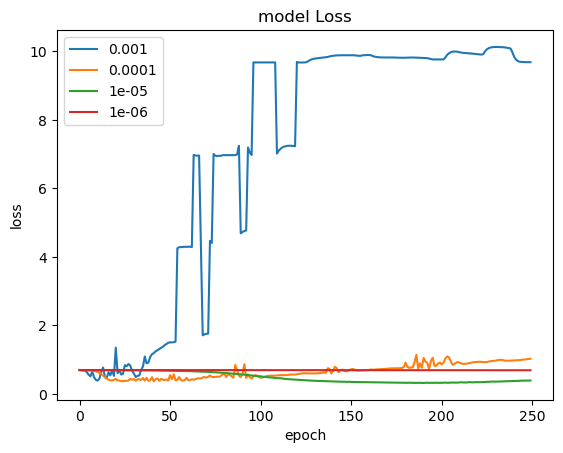

In [65]:
# summarize effect of lr vs loss
#f,ax = plt.subplots(1,2,figsize=(16,12))
import matplotlib.pyplot as plt
for i in lrs_data.values():
    plt.plot(i['val_loss'])

plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(list(lrs_data.keys()), loc='upper left')
plt.show()

lrs= list(lrs_data.keys())
lrs.remove(str(0.001))
for i in lrs:
    plt.plot(lrs_data[i]['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(lrs, loc='upper left')
plt.show()


### Studying Effects of beta/momentum of Adam Optimizer


In [75]:

from scipy.stats import loguniform
# sampling betas
a = 1-1e-1
b= 1-1e-3
betas = loguniform.rvs(a, b, size=5)
betas_data={}
for i in betas:
    print("------Training for beta {}---------".format(i))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(test_data_pol.num_features,[best_trial['params']['layer_size1'],best_trial['params']['layer_size2'],best_trial['params']['layer_size3'],
                                            best_trial['params']['layer_size4'],best_trial['params']['layer_size5'],best_trial['params']['layer_size6']],1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_trial['params']['learning_rate'],betas=(i,0.99))
    lossff = torch.nn.BCELoss()
    print(device)

    print("Number of Parameters of the model :",sum([param.nelement() for param in model.parameters()]))
    print(model)
    betas_data[i] = {"val_loss":[],"test_loss":[],'train_loss':[]}
    for epoch in range(200):
        train_loss = train(epoch)
        test_loss, test_acc, test_f1 = test(epoch)
        val_loss, val_acc, val_f1 = val(epoch)
        betas_data[i]['val_loss'].append(val_loss)
        betas_data[i]['test_loss'].append(test_loss)
        betas_data[i]['train_loss'].append(train_loss)

        print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.5f} | '
                f'ValLoss: {val_loss:.5f} | ValAcc: {val_acc:.5f} | ValF1: {val_f1:.2f} | '
                f'TestLoss: {test_loss:.5f} | TestAcc: {test_acc:.5f} | TestF1: {test_f1:.2f}'
                            )
        # print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.7f} |')

------Training for beta 0.9494745743057798---------
cpu
Number of Parameters of the model : 1656769
Net(
  (conv1): SAGEConv(768, 512, aggr=mean)
  (conv2): SAGEConv(512, 512, aggr=mean)
  (conv3): SAGEConv(512, 256, aggr=mean)
  (full1): Linear(in_features=256, out_features=64, bias=True)
  (full2): Linear(in_features=64, out_features=512, bias=True)
  (full3): Linear(in_features=512, out_features=64, bias=True)
  (full4): Linear(in_features=64, out_features=1, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (dp2): Dropout(p=0.2, inplace=False)
  (dp3): Dropout(p=0.2, inplace=False)
)
Epoch: 00 |  TrainLoss: 0.69593 | ValLoss: 0.70271 | ValAcc: 0.41935 | ValF1: 0.00 | TestLoss: 0.68588 | TestAcc: 0.58065 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.69547 | ValLoss: 0.70215 | ValAcc: 0.41935 | ValF1: 0.00 | TestLoss: 0.68611 | TestAcc: 0.58065 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.69518 | ValLoss: 0.70161 | ValAcc: 0.41935 | ValF1: 0.00 | TestLoss: 0.68630 | TestAcc: 0.58065 | TestF

In [ ]:

with open('beta.json') as f:
    betas_data = json.dump(betas_data,f)

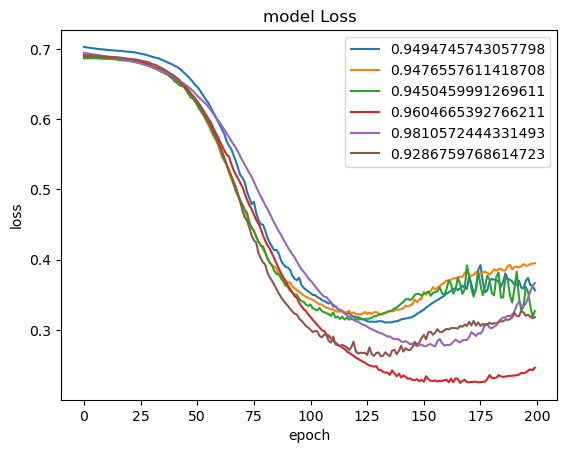

In [85]:
# summarize effect of lr vs loss
#f,ax = plt.subplots(1,2,figsize=(16,12))
import matplotlib.pyplot as plt
for i in betas_data.values():
    plt.plot(i['val_loss'])

plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(list(betas_data.keys()), loc='upper right')
plt.show()

# betas= list(betas_data.keys())
# # betas.remove(str(0.001))
# for i in betas:
#     plt.plot(betas_data[i]['val_loss'])
# plt.title('model Loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(lrs, loc='upper right')
# plt.show()
